In [1]:
from __future__ import print_function
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
%matplotlib inline
from utils import *
import torch
import random
from PIL import Image,ImageFilter
import pickle
from torchvision.transforms import functional as FT
from torch.autograd import Variable
from torch.utils.data import Dataset

C:\Users\20203666\Documents\BEP\code\Representation_Learning


In [2]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = 10
batch_size = 500

mean_id = [0.4524, 0.4525, 0.4690]  # mean along channels
std_id=[0.12252066, 0.12827758, 0.1144258 ]
# Define normalization transformation
normalize_transform_id = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_id, std_id)])

train_dataset_id =  datasets.SVHN(
    root= './data', split = 'train',
    download =True, transform=normalize_transform_id)
test_dataset_id  = datasets.SVHN(
    root= './data', split = 'test',
    download =True, transform=normalize_transform_id)

class_indices = {i: [] for i in range(10)}
for idx, (_, label) in enumerate(test_dataset_id):
    class_indices[label].append(idx)

# Select 1,000 random indices for each class
selected_indices = []
for label, indices in class_indices.items():
    selected_indices.extend(indices[:1000])

test_dataset_id = torch.utils.data.Subset(test_dataset_id, selected_indices)

train_loader_id = torch.utils.data.DataLoader(train_dataset_id
                                              , batch_size = batch_size
                                              , shuffle = True)
test_loader_id = torch.utils.data.DataLoader(test_dataset_id
                                             , batch_size = batch_size
                                             , shuffle = True)
n_total_step = len(train_loader_id)
print(n_total_step)

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat
147


In [3]:
classifier = nn.Linear(512, num_classes)
neta = resnet9(classifier, mod=True)
neta = load_net('2512svv1.t7', neta).to(device)
criterion_sm = CE_Loss(neta.classifier, num_classes).to(device)
sgd = optim.SGD([{'params': neta.parameters()}, ],
                lr=0.1, momentum=0.9, weight_decay=5e-4)
optimizer = Optimizer(sgd, train_loader_id, device)
(acc, conf) = optimizer.test_acc(neta, criterion_sm, test_loader_id)

2512svv1.t7 ACC:	 tensor(95.8700)
Loss: 0.200 | Acc: 95.580% (9558/10000) | Conf 97.62


In [4]:
def logsumexp(logits):
    return torch.logsumexp(logits, dim=0, keepdim=False)

def predict_energy(net, test_loader, temperature, threshold):
    predictions = []
    net.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to('cuda'), targets.to('cpu')
            outputs = net.forward(inputs).to('cpu')
            outputs = outputs / temperature
            softmax_outputs = F.softmax(outputs)
            confBatch, predicted = softmax_outputs.max(1)

            for i in range(len(predicted)):
                energy = -temperature*logsumexp(outputs[i])
                if energy>threshold:
                    prediction = (1,  int(predicted[i]), float(confBatch[i]), targets[i], energy)
                else:
                    prediction = (0, int(predicted[i]), float(confBatch[i]), targets[i], energy)
                predictions.append(prediction)
            print(len(predictions))
            if len(predictions) ==10000:
                break

    return predictions

def fit_energy(net, test_loader, temperature):
    energy_scores = []
    net.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to('cuda'), targets.to('cpu')
            outputs = net.forward(inputs).to('cpu')
            outputs = outputs / temperature
            softmax_outputs = F.softmax(outputs)
            confBatch, predicted = softmax_outputs.max(1)
            for i in range(len(predicted)):

                energy = -temperature*logsumexp(outputs[i])
                energy_scores.append(energy)
    percentile_95 = np.percentile(energy_scores, 95)
    return percentile_95

def predict_energy_grad(net, test_loader, temperature, threshold):
    predictions = []
    net.eval()

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        with torch.no_grad():
            inputs, targets = inputs.to('cuda'), targets.to('cpu')
            outputs = net.forward(inputs).to('cpu')
            outputs = outputs / temperature
            softmax_outputs = F.softmax(outputs)
            confBatch, predicted = softmax_outputs.max(1)

            for i in range(len(predicted)):
                energy = -temperature*logsumexp(outputs[i])
                if energy>threshold:
                    prediction = (1,  int(predicted[i]), float(confBatch[i]), targets[i], energy)
                else:
                    prediction = (0, int(predicted[i]), float(confBatch[i]), targets[i], energy)
                predictions.append(prediction)
            print(len(predictions))
            if len(predictions) ==10000:
                break

    return predictions

def calc_FPR95(preds):
    id=1
    acc=0
    acc2=0
    for i in range(len(preds)):
        if preds[i][0] == 0:
            id+=1
        if preds[i][1]==preds[i][3] and preds[i][0] == 0:
            acc+=1
        if preds[i][1]==preds[i][3]:
            acc2+=1
    print(f'percentage ID: {id/10000}, percentage accurate total: {acc2/10000}, percentage accurate and ID: {acc/10000},'
          f' percentage accurate of ID: {acc/id}')

def plot_hist(preds_id, preds_ood, threshold):
    id_data=[]
    ood_data=[]
    for i in range(len(preds_id)):
        id_data.append(preds_id[i][4])
        ood_data.append(preds_ood[i][4])

    bin_edges = np.linspace(min(min(id_data), min(ood_data)), max(max(id_data), max(ood_data)), 50)  # 30 bins

    plt.hist(id_data, bins=bin_edges, alpha=0.5, label='ID data', color='blue')
    plt.hist(ood_data, bins=bin_edges, alpha=0.5, label='OOD data', color='orange')
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({round(float(threshold),4)})')

    # Adding labels and title
    plt.xlabel('OOD detection method score')
    plt.ylabel('Frequency')
    plt.yticks([])
    plt.legend()

    # Displaying the plot
    plt.show()
from sklearn.metrics import roc_auc_score,roc_curve, auc
def calc_auroc(preds_id, preds_ood):
    id_labels = [1]*10000
    ood_labels = [0]*10000
    id_data=[]
    ood_data=[]
    for i in range(len(preds_id)):
        id_data.append(-1*preds_id[i][4])
        ood_data.append(-1*preds_ood[i][4])
    data = id_data+ ood_data
    labels = id_labels+ ood_labels
    auroc = roc_auc_score(labels, data)
    fpr, tpr, thresholds = roc_curve(labels, data)
    print(f'AUROC: {auroc}')
    roc_auc = auc(fpr, tpr)
    idx = next(i for i, v in enumerate(tpr) if v >= 0.95)
    fpr_at_tpr_95 = fpr[idx]

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {roc_auc:.2f}')
    #plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    #plt.ylim(0.5, 1)
    plt.axvline(x=fpr_at_tpr_95, color='red', linestyle='--', label='TPR = 0.95')
    plt.legend(loc='lower right')
    plt.show()


In [5]:
temp = 10
threshold = fit_energy(neta, test_loader_id, temp)
print(threshold)
preds_id = predict_energy(neta, test_loader_id, temp, threshold)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


-22.680559730529783


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


In [6]:
calc_FPR95(preds_id)

percentage ID: 0.9501, percentage accurate total: 0.9558, percentage accurate and ID: 0.9236, percentage accurate of ID: 0.9721081991369329


In [7]:

mean_cifar = (0.4914, 0.4822, 0.4465)  # Calculate mean along channels
std_cifar = (0.2023, 0.1994, 0.2010)  # Calculate std along channels

normalize_transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_id, std_id)])


dataset_cifar = datasets.CIFAR10(
    root= './data', train = False,
    download =True, transform = normalize_transform_cifar)

loader_cifar = torch.utils.data.DataLoader(dataset_cifar
                                           , batch_size = batch_size
                                           , shuffle = True)

Files already downloaded and verified


In [8]:
preds_cifar = predict_energy(neta, loader_cifar, temp, threshold)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


In [9]:
calc_FPR95(preds_cifar)

percentage ID: 0.2411, percentage accurate total: 0.1011, percentage accurate and ID: 0.0233, percentage accurate of ID: 0.0966403981750311


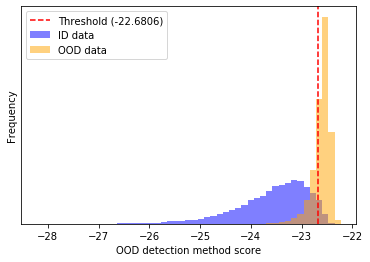

AUROC: 0.958017275


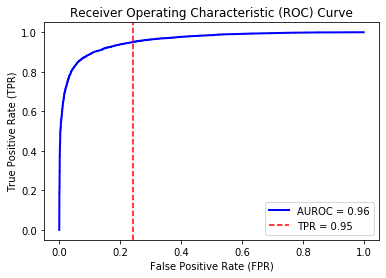

In [10]:
plot_hist(preds_id, preds_cifar, threshold)
calc_auroc(preds_id, preds_cifar)

In [11]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize the image to 32x32
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel image
    transforms.ToTensor(),
    transforms.Normalize(mean_id, std_id)  # Convert image to tensor # Expand single channel to three channels
])

dataset_domain_shift = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

loader_domain_shift = torch.utils.data.DataLoader(dataset_domain_shift
                                                  , batch_size=batch_size
                                                  , shuffle=False)
preds_domain_shift = predict_energy(neta, loader_domain_shift, temp, threshold)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


In [12]:
calc_FPR95(preds_domain_shift)

percentage ID: 0.6685, percentage accurate total: 0.6955, percentage accurate and ID: 0.5408, percentage accurate of ID: 0.8089753178758414


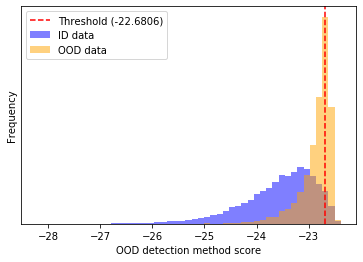

AUROC: 0.85118332


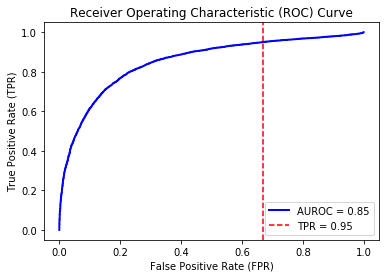

In [13]:
plot_hist(preds_id, preds_domain_shift, threshold)

calc_auroc(preds_id, preds_domain_shift)

In [6]:


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        # Add Gaussian noise to the tensor
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noisy_tensor = tensor + noise

        # Clip pixel values to maintain range between 0 and 1
        noisy_tensor = torch.clamp(noisy_tensor, 0., 1.)
        return noisy_tensor


noise_level = 0.075

# Define normalization transformation
normalize_transform_noise = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(mean=0.0, std=noise_level),
    transforms.Normalize(mean_id, std_id)])


dataset_noise = datasets.SVHN(
    root= './data', split = 'test',
    download =True, transform=normalize_transform_noise)

dataset_noise = torch.utils.data.Subset(dataset_noise, selected_indices)

loader_noise = torch.utils.data.DataLoader(dataset_noise
                                           , batch_size=batch_size
                                           , shuffle=False)
preds_noise = predict_energy(neta, loader_noise, temp, threshold)

Using downloaded and verified file: ./data\test_32x32.mat


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


In [7]:
calc_FPR95(preds_noise)

percentage ID: 0.8716, percentage accurate total: 0.8765, percentage accurate and ID: 0.8133, percentage accurate of ID: 0.9331115190454337


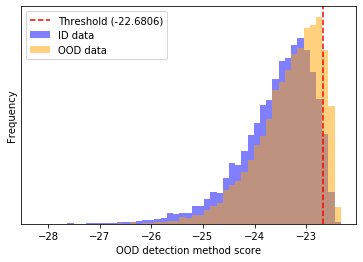

AUROC: 0.605232505


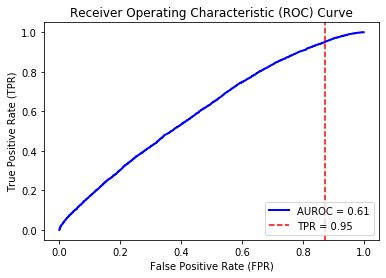

In [8]:
plot_hist(preds_id, preds_noise, threshold) #0.025
calc_auroc(preds_id, preds_noise)

In [14]:


class AddBlur(object):
    def __init__(self, radius=2):
        self.radius = radius

    def __call__(self, img):
        pil_img = transforms.ToPILImage()(img)  # Convert Tensor to PIL Image
        blurred_img = pil_img.filter(ImageFilter.GaussianBlur(radius=self.radius))  # Apply Gaussian blur
        return transforms.ToTensor()(blurred_img)


blur_level = 2

# Define normalization transformation
normalize_transform_blur = transforms.Compose([
    transforms.ToTensor(),
    AddBlur(radius=blur_level),
    transforms.Normalize(mean_id, std_id)])


dataset_blur = datasets.SVHN(
    root= './data', split = 'test',
    download =True, transform=normalize_transform_blur)

dataset_blur = torch.utils.data.Subset(dataset_blur, selected_indices)

loader_blur = torch.utils.data.DataLoader(dataset_blur
                                          , batch_size=batch_size
                                          , shuffle=False)
preds_blur = predict_energy(neta, loader_blur, temp, threshold)

Using downloaded and verified file: ./data\test_32x32.mat


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


In [15]:
calc_FPR95(preds_blur)

percentage ID: 0.9033, percentage accurate total: 0.8934, percentage accurate and ID: 0.8456, percentage accurate of ID: 0.9361231041735858


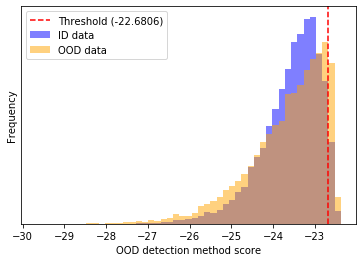

AUROC: 0.49511117499999996


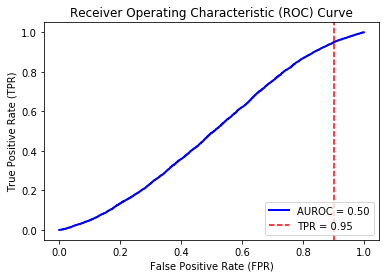

In [16]:
plot_hist(preds_id, preds_blur, threshold) #0.075
calc_auroc(preds_id, preds_blur)

In [10]:


# FGSM attack to generate adversarial examples
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


# Custom transformation to apply FGSM attack
class AdversarialAttack(object):
    def __init__(self, model, epsilon=0.1):
        self.epsilon = epsilon
        self.model = model

    def __call__(self, img):
        criterion = torch.nn.CrossEntropyLoss().cuda()
        input = Variable(img.cuda(), requires_grad=True)
        output = self.model(input.unsqueeze(0))  # Assuming 'model' is your trained model
        _, pred = output.max(1)
        loss = criterion(output, pred)
        loss.backward()
        data_grad = input.grad.data
        perturbed_img = fgsm_attack(input, self.epsilon, data_grad)
        perturbed_img = perturbed_img.squeeze(0)
        perturbed_img = perturbed_img.to('cpu')
        perturbed_img = perturbed_img.detach()
        return perturbed_img


attack_level = 0.15

# Define normalization transformation
normalize_transform_adversarial = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_id, std_id),
    AdversarialAttack(model=neta, epsilon=attack_level)])


dataset_adversarial = datasets.SVHN(
    root= './data', split = 'test',
    download =True, transform=normalize_transform_adversarial)

dataset_adversarial = torch.utils.data.Subset(dataset_adversarial, selected_indices)

loader_adversarial = torch.utils.data.DataLoader(dataset_adversarial
                                                 , batch_size=batch_size
                                                 , shuffle=False)

preds_adversarial = predict_energy_grad(neta, loader_adversarial, temp, threshold)

Using downloaded and verified file: ./data\test_32x32.mat


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


In [11]:
calc_FPR95(preds_adversarial)

percentage ID: 0.5792, percentage accurate total: 0.3372, percentage accurate and ID: 0.1954, percentage accurate of ID: 0.33736187845303867


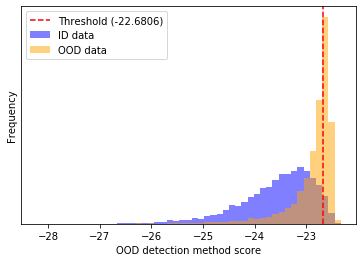

AUROC: 0.837785795


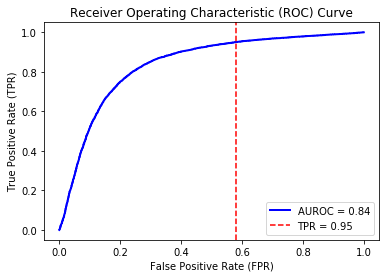

In [12]:
plot_hist(preds_id, preds_adversarial, threshold) #0.075
calc_auroc(preds_id, preds_adversarial)

Using downloaded and verified file: ./data\test_32x32.mat


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
percentage ID: 0.8791, percentage accurate total: 0.8977, percentage accurate and ID: 0.8405, percentage accurate of ID: 0.9560914571721079


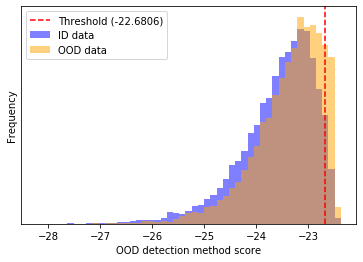

AUROC: 0.590809895


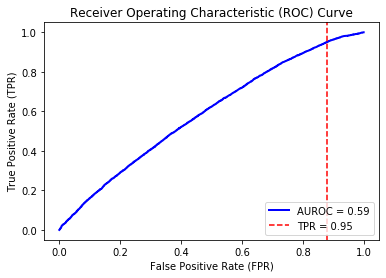

In [9]:
class AddBrightness(object):
    def __init__(self, brightness=1, contrast=1, saturation=1, hue=0, randomhue=False):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.randomhue = randomhue
    def __call__(self, img):

        # Apply color shift deterministically
        img = FT.adjust_brightness(img, self.brightness)
        img = FT.adjust_contrast(img, self.contrast)
        img = FT.adjust_saturation(img, self.saturation)
        img = FT.adjust_hue(img, self.hue)
        if self.randomhue==True:
            random_number = 0  # Initialize with 5 to start the loop
            while random_number == 0 :
                random_number = random.randint(1, 10)
                random_number = (random_number-5)/10
            img = FT.adjust_hue(img, random_number)
        return img
normalize_transform_bright = transforms.Compose([
    transforms.ToTensor(),
    AddBrightness(brightness=1.75),
    transforms.Normalize(mean_id, std_id)])


dataset_bright = datasets.SVHN(
    root= './data', split = 'test',
    download =True, transform=normalize_transform_bright)
dataset_bright = torch.utils.data.Subset(dataset_bright, selected_indices)
loader_bright = torch.utils.data.DataLoader(dataset_bright
                                            , batch_size=batch_size
                                            , shuffle=False)
preds_bright= predict_energy(neta, loader_bright, temp, threshold)
calc_FPR95(preds_bright)
plot_hist(preds_id, preds_bright, threshold)  #0.075
calc_auroc(preds_id, preds_bright)